In [79]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import * 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

from scipy.interpolate import interp1d

#### Interpolate between every 2nd peak and plot residual of remaining peaks with interpolated function 

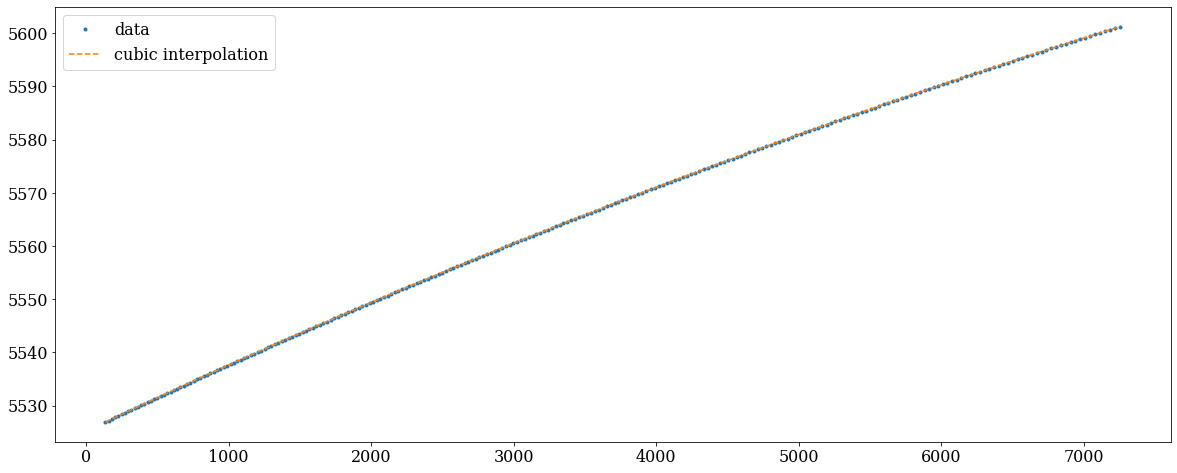

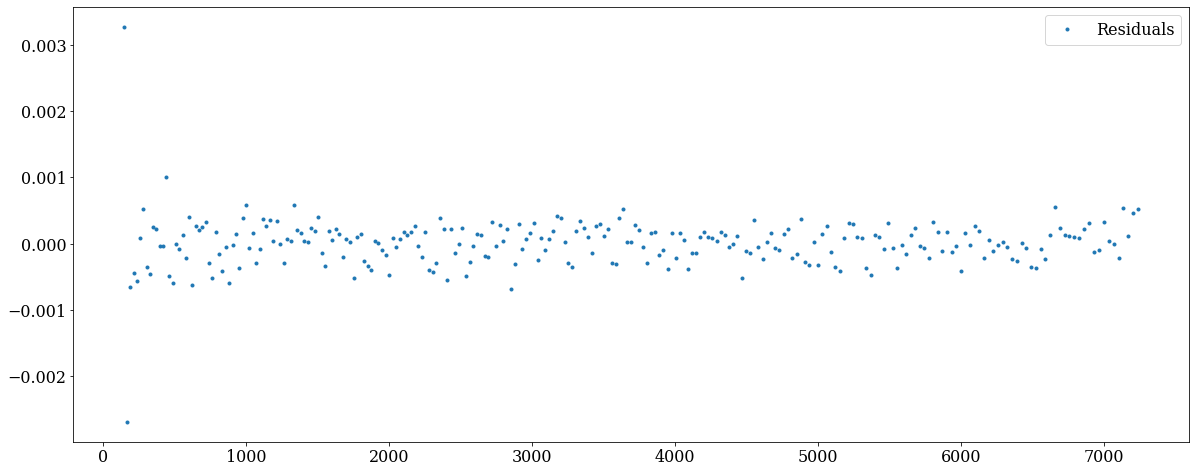

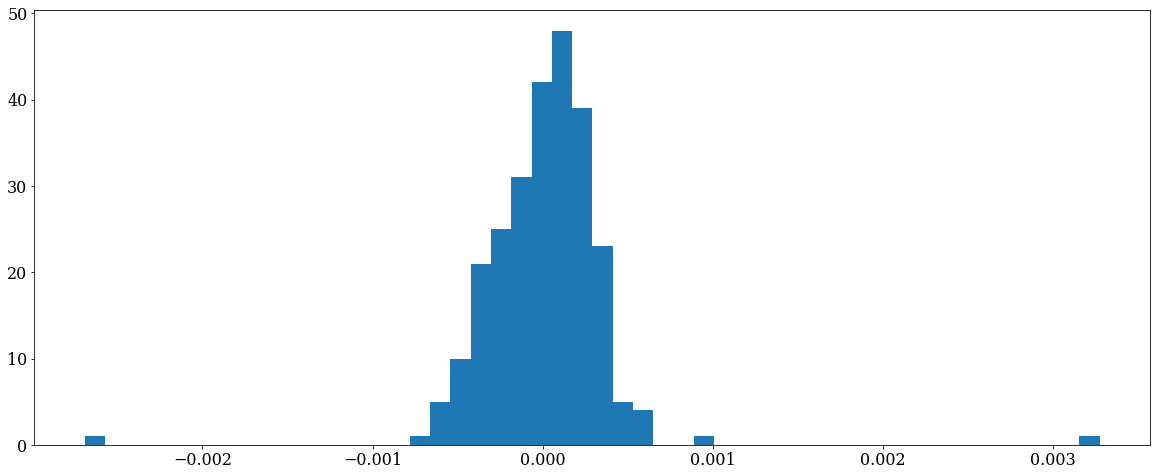

In [17]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)

order = 50
data = hdu1[1].data.copy()
data_spec       = data['spectrum'][order]
data_spec_err   = data['uncertainty'][order]
data_wavel      = data['wavelength'][order]

# Find peaks
peak_info = func_find_peaks(data_spec, 11, 0.15)
peak_locs = peak_info[0]

# Create data slices around each peak
peak_index_ranges = get_peak_index_ranges(peak_locs, peak_range_size = 14)    # TODO: find dynamic way of choosing range size

# Fit peak in each data slice
peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

# Get list of true wavelengths
wavel_true = get_true_wavel(data_wavel, peak_locs)[:, 0] # second column is the n in the true wavel peak formula

# Take every other element
x = peak_fits[:,2][::2]
y = wavel_true[::2]

f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(min(x), max(x), 1000, endpoint=True)

plt.figure(figsize=(20,8))
plt.plot(x, y, '.', xnew, f2(xnew), '--')
plt.legend(['data', 'cubic interpolation'], loc='best')

# Residuals for all x and y
plt.figure(figsize=(20,8))
x = peak_fits[:,2][1::2] # Take every other element starting at index 1 (so we get the other ones)
y = wavel_true[1::2]
residuals = f2(x) - y
plt.plot(x, residuals, ".")
plt.legend(['Residuals'], loc='best')

# Plot residuals as hist
plt.figure(figsize=(20,8))
plt.hist(residuals, bins=50);

##### Repeat for all orders

In [75]:
results = fit_all_peaks_in_all_orders(correct_errors=True)

/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:89: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:89: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)


Standard deviation is  0.19215114558158516


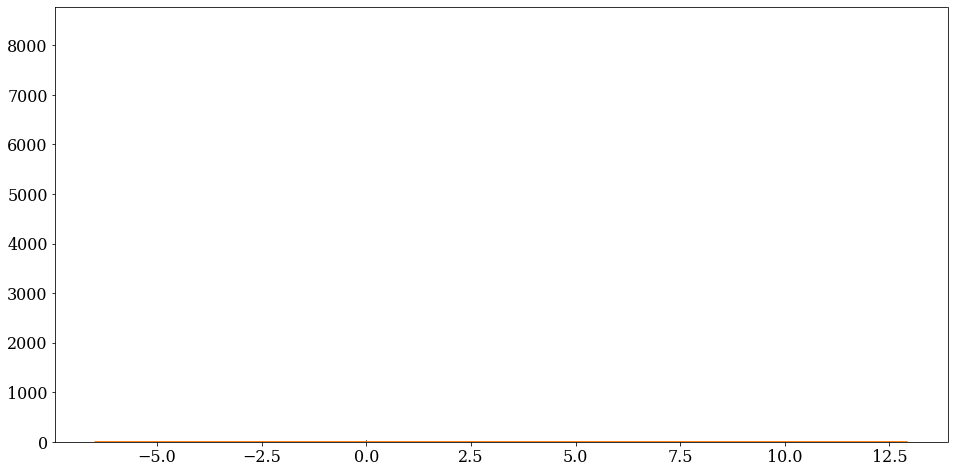

In [12]:
residuals = []
for o in range(40, 76):
    order, peak_fits, wavel_true, data_wavel = results[o]

    # Take every other element
    x = peak_fits[:,2][::2]
    y = wavel_true[::2][:, 0]

    f2 = interp1d(x, y, kind='cubic', fill_value="extrapolate") # fill_value="extrapolate" is used to extrapolate to reach the last items outside (last item in list)

    # Residuals for all x and y
    x = peak_fits[:,2][1::2] # Take every other element starting at index 1 (so we get the other ones), and skip last item
    y = wavel_true[1::2][:, 0]
    x = x[1:-1]  # first and last data points don't work well — exclude them ... TODO ?
    y = y[1:-1]
    
    res = f2(x) - y # residuals
    residuals.append(res)

    # Plot all orders
    # fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
    # plt.gca().set_title(f"{order}. order")
    # ax1.plot(x, res, ".")
    # ax2.hist(res, bins=50);
    # fig.tight_layout()


# Plot all residuals
residuals = np.concatenate(residuals)
plt.figure(figsize=(16,8))
plt.hist(residuals, bins=1000);

print("Standard deviation is ", np.std(residuals))

# Draw gauss on top
xlin = np.linspace(min(residuals), max(residuals), 1000)
plt.plot(xlin, 0.035 * stats.norm.pdf(xlin, np.mean(residuals), np.std(residuals)))

# Save residuals to .csv
# np.savetxt("fit_results/residuals_interp_2nd_cropped.csv", residuals, delimiter=",")


#### Do interpolation for all peaks, by using every 2nd and flipping around 

17032 residuals
Standard deviation is  0.9336073845515256


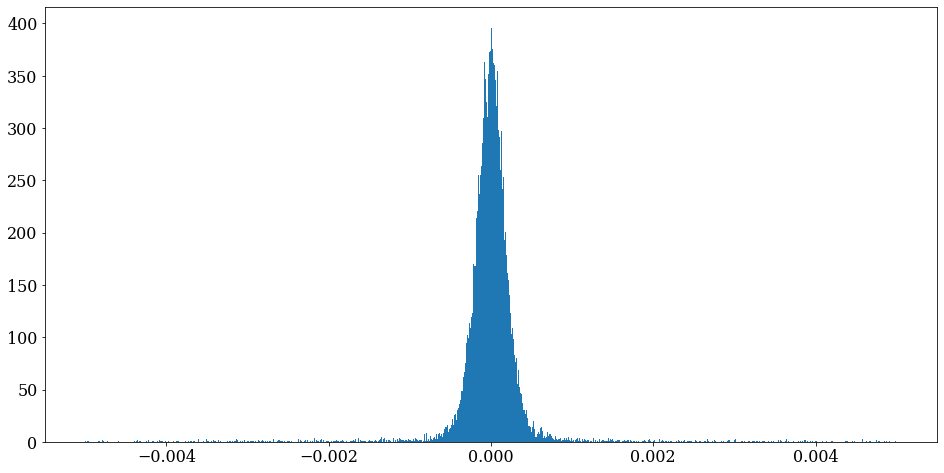

In [76]:
def compute_res(list, omit_first=False):
    for o in range(40, 76):

        order, peak_fits, wavel_true, data_wavel = results[o]
        
        if omit_first:
            order, peak_fits, wavel_true, data_wavel = order, peak_fits[1:], wavel_true[1:], data_wavel[1:]

        # Take every other element
        x = peak_fits[:,2][::2]
        y = wavel_true[::2][:, 0]

        f2 = interp1d(x, y, kind='cubic', fill_value="extrapolate") # fill_value="extrapolate" is used to extrapolate to reach the last items outside (last item in list)

        # Residuals for all x and y
        x = peak_fits[:,2][1::2] # Take every other element starting at index 1 (so we get the other ones), and skip last item
        y = wavel_true[1::2][:, 0]
        # x = x[1:-1]  # first and last data points don't work well — exclude them ... TODO ?
        # y = y[1:-1]
        
        res = f2(x) - y # residuals
        list.append(res)



residuals = []

# Compute 1st half
compute_res(residuals)

# Compute 2nd half by skipping first item
compute_res(residuals, omit_first=True)

# Collapse to one list
residuals = np.concatenate(residuals)

# Print nubmer of residuals
print(len(residuals), "residuals")

# Plot
plt.figure(figsize=(16,8))
plt.hist(residuals, bins=1000, range=(-0.005, 0.005));

print("Standard deviation is ", np.std(residuals))

# Draw gauss on top
# xlin = np.linspace(min(residuals), max(residuals), 1000)
# plt.plot(xlin, 0.035 * stats.norm.pdf(xlin, np.mean(residuals), np.std(residuals)))

# Save residuals to .csv
np.savetxt("fit_results/residuals_interp_all_peaks_every_2nd_flipped_with_errors_sqrt3.csv", residuals, delimiter=",")


### Compare to 6 degree poly fit

Polyfit:
18373 points, min = -274949.90364456695, max = 212021.6683722637
Interp:
17032 points, min = -78.37242234366386, max = 55.90654935657585


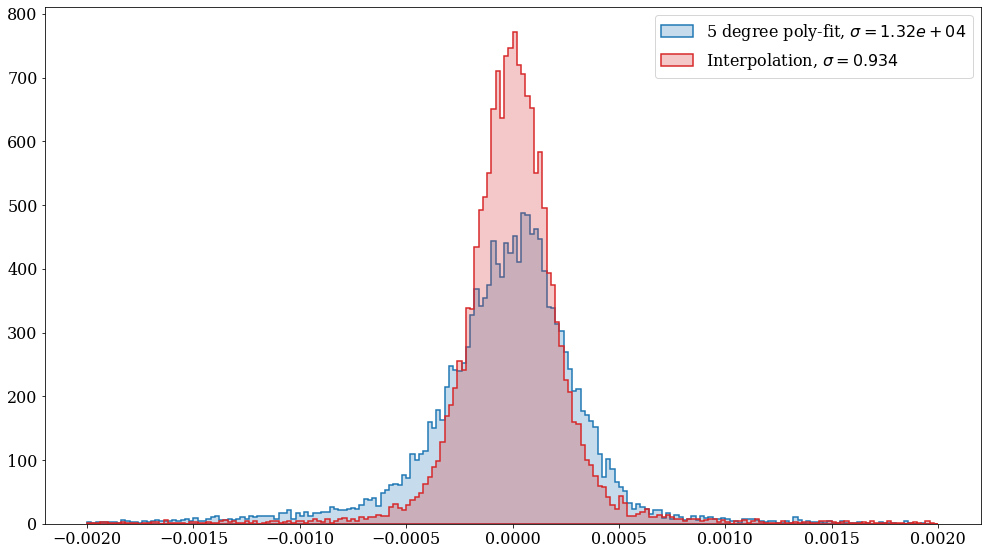

In [78]:
from matplotlib import colors

def print_res_info(res):
    res_min, res_max = np.nanmin(res), np.nanmax(res)
    res_len = len(res)
    print(f"{res_len} points, min = {res_min}, max = {res_max}")


res_fit5 = np.genfromtxt("fit_results/residuals_5degree_fit.csv")
res_fit6 = np.genfromtxt("fit_results/residuals_6degree_fit.csv")
# res_interp = np.genfromtxt("fit_results/residuals_interp_2nd_cropped.csv")
# res_interp = np.genfromtxt("fit_results/residuals_interp_all_peaks_every_2nd_flipped.csv")
res_interp = np.genfromtxt("fit_results/residuals_interp_all_peaks_every_2nd_flipped_with_errors_sqrt3.csv")

print("Polyfit:")
print_res_info(res_fit5)

print("Interp:")
print_res_info(res_interp)


plt.figure(figsize=(14, 8))
mRange = (-0.002, 0.002)
# mRange = (-1000, 100)
plt.hist(res_fit5, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label=f"5 degree poly-fit, $ \sigma= {np.std(res_fit5):.3}$");
plt.hist(res_interp, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C3', 0.25), edgecolor="C3", lw=1.5, label=f"Interpolation, $ \sigma = {np.std(res_interp):.3}$");
# plt.hist(res_fit6, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label="6 degree poly fit");
# plt.title("Individual peak residuals across orders 40-76")
# plt.legend(loc=[0.6, 0.8])
plt.legend(loc="upper right")
# plt.yscale('log')
plt.tight_layout()
plt.savefig("figures/problem1/hist_peak_residuals_poly_and_interp.png", dpi=300)


(1.7899265384383779e+19, 13239.38863158647)

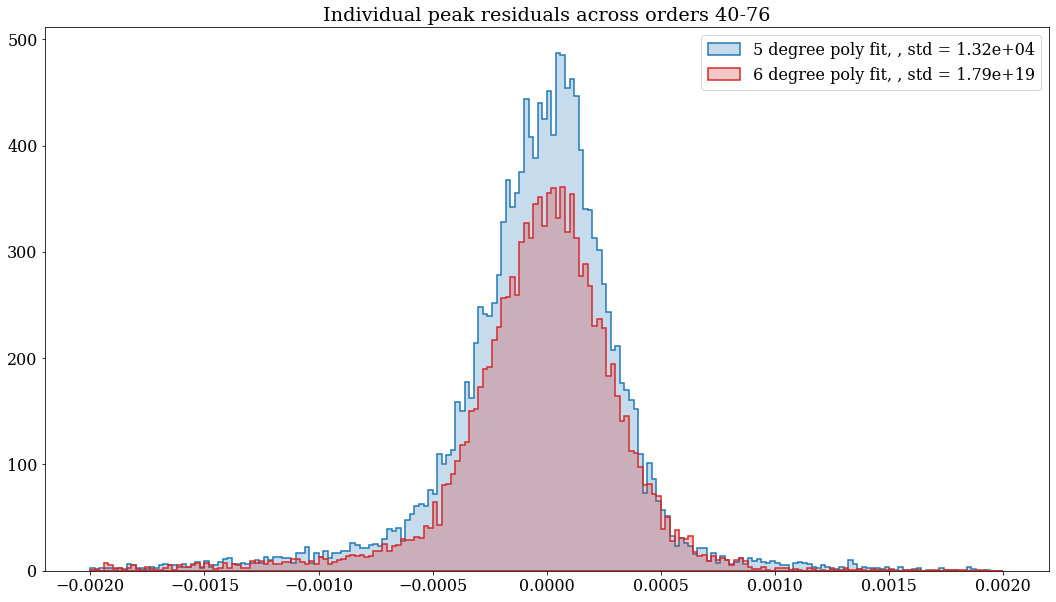

In [68]:
from matplotlib import colors

res_fit5 = np.genfromtxt("fit_results/residuals_5degree_fit.csv")
res_fit6 = np.genfromtxt("fit_results/residuals_6degree_fit.csv")

plt.figure(figsize=(18, 10))
mRange = (-0.002, 0.002)
plt.hist(res_fit5, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label=f"5 degree poly fit, , std = {np.std(res_fit5):.3}");
plt.hist(res_fit6, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C3', 0.25), edgecolor="C3", lw=1.5, label=f"6 degree poly fit, , std = {np.std(res_fit6):.3}");
plt.title("Individual peak residuals across orders 40-76")
plt.legend()

np.std(res_fit6), np.std(res_fit5)

### Save interpolation function for calibration use

In [105]:
# for o in range(40, 76):
o = 45
order, peak_fits, wavel_true, data_wavel = results[o]

# Take every other element
x = peak_fits[:,2][::2]
y = wavel_true[::2][:, 0]

f2 = interp1d(x, y, kind='cubic', fill_value="extrapolate") # fill_value="extrapolate" is used to extrapolate to reach the last items outside (last item in list)

f2(4032)

# Save scipy object
np.save(f"fit_results/interp_order{o}.npy", f2, allow_pickle=True)

# To load scipy object
# f3 = np.load("fit_results/interpolation.sci.npy", allow_pickle=True).item(0)


array(5329.00576727)

#### Compute interpolation sigma for different error correction factors

In [ ]:
# Include interpolation sigma check
def compute_interp_sigma(results):

    def compute_res(list, omit_first=False):
        for o in range(40, 76):

            order, peak_fits, wavel_true, data_wavel = results[o]
            
            if omit_first:
                order, peak_fits, wavel_true, data_wavel = order, peak_fits[1:], wavel_true[1:], data_wavel[1:]

            # Take every other element
            x = peak_fits[:,2][::2]
            y = wavel_true[::2][:, 0]

            f2 = interp1d(x, y, kind='cubic', fill_value="extrapolate") # fill_value="extrapolate" is used to extrapolate to reach the last items outside (last item in list)

            # Residuals for all x and y
            x = peak_fits[:,2][1::2] # Take every other element starting at index 1 (so we get the other ones), and skip last item
            y = wavel_true[1::2][:, 0]
            # x = x[1:-1]  # first and last data points don't work well — exclude them ... TODO ?
            # y = y[1:-1]
            
            res = f2(x) - y # residuals
            list.append(res)



    residuals = []

    # Compute 1st half
    compute_res(residuals)

    # Compute 2nd half by skipping first item
    compute_res(residuals, omit_first=True)
    # Collapse to one list
    residuals = np.concatenate(residuals)
    
    return np.std(residuals)


sigmas = []
for s in np.arange(2, 8):
    results = fit_all_peaks_in_all_orders(correct_errors=True, custom_error_factor=np.sqrt(s))
    sigma = compute_interp_sigma(results)
    sigmas.append(sigma)

